# Imports and model initialization

In [64]:
# !pip install kipoi
# !pip install kipoiseq
# !pip install pybedtools
# !pip uninstall -y kipoi_veff
# !pip install git+https://github.com/an1lam/kipoi-veff
# !pip install pyvcf
import csv
import math
import pickle

from Bio.motifs import pfm
import kipoi
from kipoi_interpret.importance_scores.ism import Mutation
from kipoiseq.dataloaders import SeqIntervalDl
from logomaker import Logo
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import cm
import numpy as np
import pandas
from tqdm import tqdm

from align import prob_sw
from utils import INT_TO_BASES
from utils import one_hot_decode

In [2]:
!pwd

/home/stephenmalina/project/src


# Loading DNA sequence data

In [3]:
dl = SeqIntervalDl("../dat/50_random_seqs_2.bed", "../dat/hg19.fa", auto_resize_len=1000)
data = dl.load_all()

100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


In [4]:
seqs = np.expand_dims(data['inputs'].transpose(0, 2, 1), 2).astype(np.float32)
seqs.shape

(50, 4, 1, 1000)

# Loading DeepSEA

In [35]:
import tensorflow as tf
print("TF version:", tf.__version__)
import torch
print("torch version:", torch.__version__)
from torch import nn
from torch.nn import functional as F

TF version: 1.15.0
torch version: 1.3.1


In [6]:
# df = kipoi.list_models()
# deepsea_models = df[df.model.str.contains("DeepSEA")]
# deepsea_models.head()

In [7]:
deepsea = kipoi.get_model("DeepSEA/predict", source="kipoi")
deepsea.model

Using downloaded and verified file: /home/stephenmalina/.kipoi/models/DeepSEA/predict/downloaded/model_files/weights/89e640bf6bdbe1ff165f484d9796efc7


Sequential(
  (0): ReCodeAlphabet()
  (1): ConcatenateRC()
  (2): Sequential(
    (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
    (1): Threshold(threshold=0, value=1e-06)
    (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
    (5): Threshold(threshold=0, value=1e-06)
    (6): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(480, 960, kernel_size=(1, 8), stride=(1, 1))
    (9): Threshold(threshold=0, value=1e-06)
    (10): Dropout(p=0.5, inplace=False)
    (11): Lambda()
    (12): Sequential(
      (0): Lambda()
      (1): Linear(in_features=50880, out_features=925, bias=True)
    )
    (13): Threshold(threshold=0, value=1e-06)
    (14): Sequential(
      (0): Lambda()
      (1): Linear(in_features=925, out_features=919, bias=True)
    )
    (15):

In [8]:
CHROM_ACC_COL = 'HepG2_DNase_None'
# TF_COL = 'A549_CTCF_None'
TF_COL = 'HepG2_FOXA1_None'
relevant_cols = sorted([(i, label)
                        for i, label in enumerate(deepsea.schema.targets.column_labels)
                        if label in [CHROM_ACC_COL, TF_COL]])

In [9]:
deepsea.pipeline.predict_example().shape

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


(10, 919)

# Loading Predictions

In [10]:
import pickle
# pickle_file = "../dat/most_recent_sat_mut_results__drop_channel.pickle"
pickle_file = "../dat/most_recent_sat_mut_results__original_mc_dropout.pickle"

In [11]:
with open(pickle_file, 'rb') as f: np_preds = pickle.load(f)
print(np_preds.shape)
epochs, n_seqs, n_batches, batch_size, _ = np_preds.shape
np_preds.shape

(50, 50, 10, 301, 3)


(50, 50, 10, 301, 3)

In [12]:
all_zeros = np.zeros((4,))

def batches_needed(seq_len, batch_size, alpha_size=4):
    assert ((seq_len * (alpha_size-1)) % (batch_size-1)) == 0, seq_len * 3
    # alpha_size - 1 mutations per nt and then account for ref in each batch
    return (seq_len * (alpha_size-1)) // (batch_size-1)

def generate_wt_mut_batches(seq, batch_size):
    """
    For a given sequence, generate all possible point-mutated versions of the sequence
    in batches of size `param:batch_size`.
    
    Args:
        seq (numpy.ndarray [number of base pairs, sequence length]): 
            wild type sequence.
        batch_size (int): size of returned batches. Note that each batch will have the
            wild type sequence as its first row since we need to compute wild type / mut
            prediction diffs using predictions generated by the same dropout mask.
    """
    num_nts, seq_len = seq.shape
    n_batches = batches_needed(seq_len, batch_size, alpha_size=num_nts)
    seq_batch = seq[np.newaxis, :, :].repeat(batch_size, axis=0)
    seq_batches = seq_batch[np.newaxis, :, :, :].repeat(n_batches, axis=0)
    i = 0
    for seq_idx in range(seq_len):  # iterate over sequence 
        for nt_idx in range(num_nts):  # iterate over nucleotides
            curr_batch, curr_idx = i // (batch_size - 1), (i % (batch_size-1) + 1)
            
            curr_nt = seq[nt_idx, seq_idx]
            if int(curr_nt) == 1: continue

            seq_batches[curr_batch, curr_idx, :, seq_idx] = all_zeros
            seq_batches[curr_batch, curr_idx, nt_idx, seq_idx] = 1
            i += 1
    return seq_batches

In [13]:
def next_seq(it):
    return (np
            .expand_dims(next(it)["inputs"].transpose(0, 2, 1), 2)
            .astype(np.float32)
            .squeeze())

In [14]:
epochs, n_seqs, batch_size = 50, 50, 301
n_nts, _, seq_len = deepsea.schema.inputs.shape
preds = [[[] for _ in range(n_seqs)] for _ in range(epochs)]
it = dl.batch_iter(batch_size=1, num_workers=0, drop_last=False)

print(f"Generating predictions for {len(it)} seqs")
n_batches = batches_needed(seq_len, batch_size, alpha_size=n_nts)
seqs = np.zeros((n_seqs, n_nts, seq_len))
batch_size = 301
for i in tqdm(range(min(n_seqs, len(it)))):
    seq = next_seq(it)
    if np.allclose(seq, .25): raise Exception("shouldn't have empty seqs")
    seqs[i, :, :] = seq

Generating predictions for 50 seqs


100%|██████████| 50/50 [00:00<00:00, 824.75it/s]


# Loading known FOXA1 motifs

In [15]:
with open('../dat/foxa1.pfm') as f: foxa1_motifs = pfm.read(f, 'pfm-four-rows')

/opt/anaconda3/lib/python3.7/site-packages/Bio/motifs/pfm.py:333: FutureWarning: Possible nested set at position 15
  row_pattern_with_nucleotide_letter = re.compile(r"\s*([ACGT])\s*[[]*[|]*\s*([0-9.\s]+)\s*[]]*\s*")


In [16]:
ex_motif = foxa1_motifs[0]
ex_motif.pwm

{'G': (0.002242152466367713,
  0.8622620380739082,
  0.00558659217877095,
  0.026785714285714284,
  0.08705357142857142,
  0.4107142857142857,
  0.005574136008918618,
  0.005574136008918618,
  0.07700892857142858,
  0.026875699888017916,
  0.5224215246636771),
 'A': (0.014573991031390135,
  0.12094064949608063,
  0.0011173184357541898,
  0.005580357142857143,
  0.006696428571428571,
  0.53125,
  0.006688963210702341,
  0.32441471571906355,
  0.05022321428571429,
  0.4232922732362822,
  0.10089686098654709),
 'T': (0.9809417040358744,
  0.008958566629339306,
  0.9854748603351955,
  0.9598214285714286,
  0.9029017857142857,
  0.044642857142857144,
  0.08807134894091416,
  0.5518394648829431,
  0.46205357142857145,
  0.5397536394176932,
  0.2365470852017937),
 'C': (0.002242152466367713,
  0.007838745800671893,
  0.00782122905027933,
  0.0078125,
  0.0033482142857142855,
  0.013392857142857142,
  0.8996655518394648,
  0.11817168338907469,
  0.4107142857142857,
  0.010078387458006719,
  0.

In [17]:
def bio_to_np_pwm(pwm_map):
    motif_len = len(list(pwm_map.values())[0])
    np_pwm = np.zeros((len(pwm_map.keys()), motif_len))
    for i, base in INT_TO_BASES.items(): np_pwm[i, :] = pwm_map[base]
    return np_pwm
        

foxa1_pwm_maps = [motif.pwm for motif in foxa1_motifs]
foxa1_pwms = [bio_to_np_pwm(pwm_map) for pwm_map in foxa1_pwm_maps]

# Results & Analysis
## Computing summary statistics

In [18]:
log_uniform_prob = math.log(.05/(1-.05))
def compute_normalized_prob(prob, train_prob):
    # source: http://deepsea.princeton.edu/help/
    denom = 1+np.exp(-(np.log(prob/(1-prob))+log_uniform_prob-np.log(train_prob/(1-train_prob))))
    return 1 / denom

# Ratios and normalization formula drawn from here: http://deepsea.princeton.edu/media/help/posproportion.txt
tf_compute_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.02394)
chrom_acc_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.049791)

In [19]:
np_preds[:, :, :, :, 0] = chrom_acc_normalized_prob(np_preds[:, :, :, :, 0])
np_preds[:, :, :, :, 1] = compute_normalized_prob(np_preds[:, :, :, :, 1], 0.020508)
np_preds[:, :, :, :, 2] = compute_normalized_prob(np_preds[:, :, :, :, 2], 0.02394)

In [20]:
n_batches = np_preds.shape[2]
batch_size = np_preds.shape[3]
np_preds.shape

(50, 50, 10, 301, 3)

In [21]:
np_pred_means = np.mean(np_preds[:, :, :, :, :], axis=0)
np_pred_vars = np.var(np_preds, axis=0, dtype=np.float64)
np_pred_means.shape

(50, 10, 301, 3)

In [22]:
np_pred_mean_diffs = np_pred_means[:, :, 1:, :] - np_pred_means[:, :, 0:1, :] 
np_pred_mean_diffs.shape

(50, 10, 300, 3)

In [23]:
np_pred_covs = np.zeros((n_seqs, n_batches, batch_size, 2, 2, len(relevant_cols)))
for seq in range(n_seqs):
    for batch in range(n_batches):
        for col in range(len(relevant_cols)):
            ref_seq_preds = np_preds[:, seq, batch, 0, col]
            for mut in range(batch_size):
                mut_seq_preds = np_preds[:, seq, batch, mut, col]
                cov = np.cov(np.stack((ref_seq_preds, mut_seq_preds)), ddof=0) # 2x2, symmetric
                np_pred_covs[seq, batch, mut, :, :, col] = cov # off diag idx

In [24]:
np_pred_uncertainties = np.sqrt(
    np_pred_covs[:, :, 1:, 1, 1, :] + np_pred_covs[:, :, 1:, 0, 0, :] - 2 * np_pred_covs[:, :, 1:, 0, 1, :]
)

## Finding most impactful mutations
Because we're lazy and it's only 3,000 items, we're going to just sort the entire list of mutations by the absolute value of their predicted impact and then return the top 10.

Once we do that, we're going to display logos for the impact of each one and its surrounding sequence context.

In [25]:
from collections import namedtuple

MutEffect = namedtuple('MutEffect', ['eff', 'seq_idx', 'eff_idx'])

def rank_mutations_by_impact(seq, mut_effects, batch_size, feature_col=1):
    """
    For a given sequence, generate all possible point-mutated versions of the sequence
    in batches of size `param:batch_size`.
    
    Args:
        seq (numpy.ndarray [number of base pairs, sequence length]): 
            wild type sequence.
        batch_size (int): size of returned batches. Note that each batch will have the
            wild type sequence as its first row since we need to compute wild type / mut
            prediction diffs using predictions generated by the same dropout mask.
    """
    num_nts, seq_len = seq.shape
    n_batches = batches_needed(seq_len, batch_size, alpha_size=num_nts)
    mut_impacts_by_pos = []
    i = 0
    for seq_idx in range(seq_len):  # iterate over sequence 
        for nt_idx in range(num_nts):  # iterate over nucleotides
            curr_batch, curr_idx = i // (batch_size - 1), (i % (batch_size-1))
            curr_nt = seq[nt_idx, seq_idx]
            if int(curr_nt) == 1: continue

            
            mut_impacts_by_pos.append(
                MutEffect(
                    eff=mut_effects[curr_batch, curr_idx, feature_col],
                    seq_idx=(seq_idx, nt_idx),
                    eff_idx=(curr_batch, curr_idx)
                )
            )            

            i += 1
    return sorted(mut_impacts_by_pos, key=lambda me: me.eff)

In [26]:
ex_mut_effects = rank_mutations_by_impact(seqs[0, :, :], np_pred_mean_diffs[2], batch_size)
seq = seqs[0, :, :]

In [27]:
top_n_muts, context_size = 5, 5
for i in range(20):
    mut_eff = ex_mut_effects[i]
    seq_pos, nt_idx = mut_eff.seq_idx
    decoded_seq = one_hot_decode(seq)
    print(
        "Mutation - effect: %.2f, sequence position: %d, from/to: %s/%s" % 
        (mut_eff.eff, seq_pos, decoded_seq[seq_pos], INT_TO_BASES[nt_idx])
    )
    start, end = max(mut_eff.seq_idx[0] - context_size, 0), min(mut_eff.seq_idx[0] + context_size, seq.shape[1])

Mutation - effect: -0.26, sequence position: 554, from/to: G/A
Mutation - effect: -0.26, sequence position: 549, from/to: T/G
Mutation - effect: -0.25, sequence position: 553, from/to: A/T
Mutation - effect: -0.24, sequence position: 553, from/to: A/G
Mutation - effect: -0.24, sequence position: 553, from/to: A/C
Mutation - effect: -0.24, sequence position: 550, from/to: C/A
Mutation - effect: -0.24, sequence position: 552, from/to: A/T
Mutation - effect: -0.23, sequence position: 551, from/to: T/C
Mutation - effect: -0.23, sequence position: 549, from/to: T/C
Mutation - effect: -0.23, sequence position: 552, from/to: A/G
Mutation - effect: -0.23, sequence position: 550, from/to: C/T
Mutation - effect: -0.23, sequence position: 551, from/to: T/G
Mutation - effect: -0.22, sequence position: 579, from/to: G/C
Mutation - effect: -0.22, sequence position: 580, from/to: C/A
Mutation - effect: -0.21, sequence position: 554, from/to: G/C
Mutation - effect: -0.20, sequence position: 580, from/

In [28]:
print(np_pred_mean_diffs.shape)

(50, 10, 300, 3)


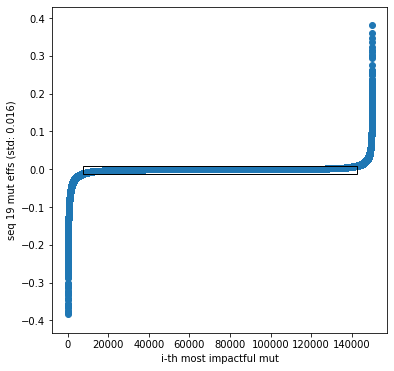

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# sample_seqs = np.random.random_integers(0, n_seqs, size=4)
y = np.sort(np_pred_mean_diffs[:, :, :, 1].reshape(-1))
x = np.arange(0, len(y))
xq1, xq2 = np.quantile(x, (.05, .95))
yq1, yq2 = np.quantile(y, (.05, .95))
rect = patches.Rectangle((xq1, yq1), xq2 - xq1, yq2 - yq1, fill=False, edgecolor='black')
rect = ax.add_patch(rect)
ax.scatter(x, y)
xlabel = "i-th most impactful mut"
ylabel = "seq {i} mut effs (std: {stddev:.3f})".format(i=i, stddev=np.std(y))
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel);

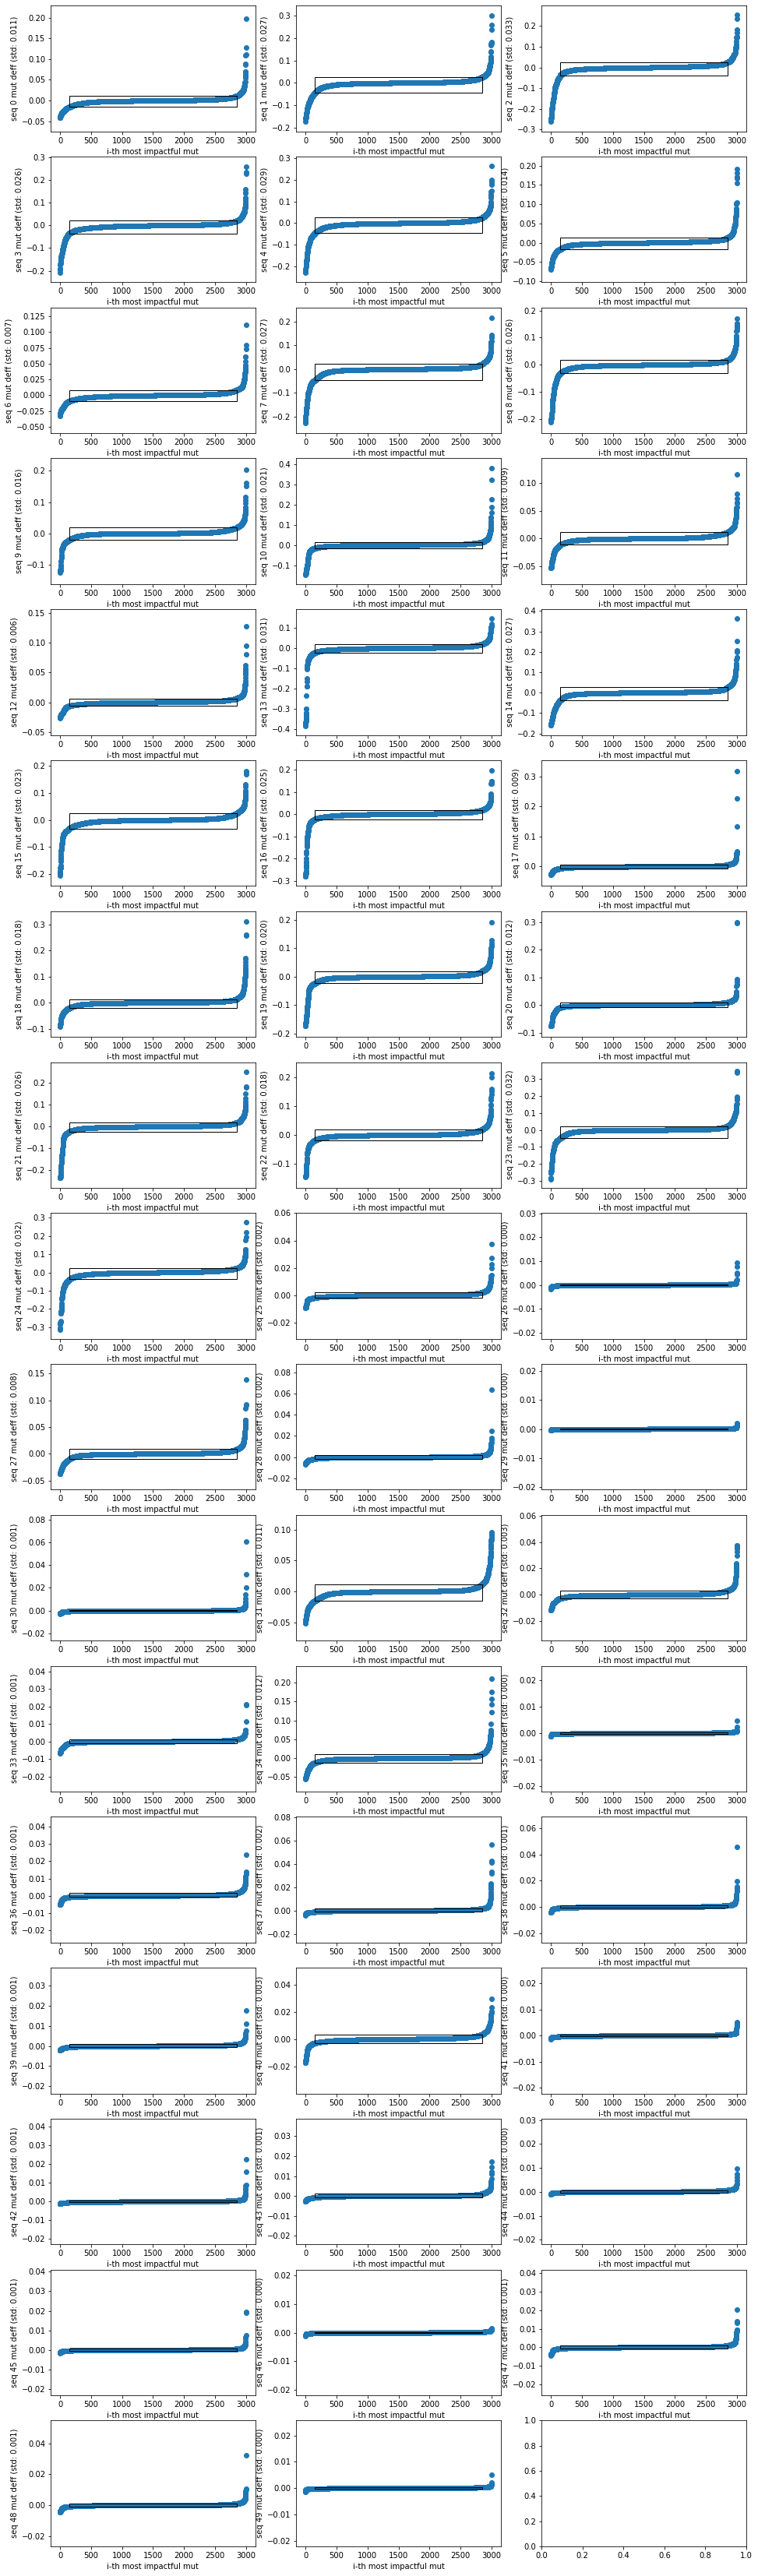

In [30]:
cols, margin = 3, 10 # margin determined empirically
fig, axs = plt.subplots(math.ceil(n_seqs / float(cols)), cols, figsize=(16, n_seqs + margin))
for i in range(n_seqs):
    ax = axs[i // cols, i % cols]

    y = np.sort(np_pred_mean_diffs[i, :, :, 1].reshape(-1))
    x = np.arange(0, len(y))
    xq1, xq2 = np.quantile(x, (.05, .95))
    yq1, yq2 = np.quantile(y, (.05, .95))
    rect = patches.Rectangle((xq1, yq1), xq2 - xq1, yq2 - yq1, fill=False, edgecolor='black')
    rect = ax.add_patch(rect)
    ax.scatter(x, y)
    xlabel = "i-th most impactful mut"
    ylabel = "seq {i} mut deff (std: {stddev:.3f})".format(i=i, stddev=np.std(y))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [50]:
neg_sig_muts, pos_sig_muts = [], []
all_mut_effs = []
for i in range(n_seqs // 2):
    
    seq = seqs[i, :, :]
    mut_effs = rank_mutations_by_impact(seq, np_pred_mean_diffs[i], batch_size)
    all_mut_effs.append(mut_effs)
    mut_eff_order_stats = np.sort(np_pred_mean_diffs[i, :, :, 1].reshape(-1))
    lq, uq = np.quantile(y, (.05, .95))
    qs = int(len(mut_eff_order_stats) * .05)
    lql, uql = mut_effs[:qs], mut_effs[-qs:]
    neg_sig_muts.append(lql)
    pos_sig_muts.append(uql)

In [32]:
print(len(neg_sig_muts[0]))

150


In [33]:
epochs, n_seqs, batch_size = 50, 50, 301
n_nts, _, seq_len = deepsea.schema.inputs.shape
preds = [[[] for _ in range(n_seqs)] for _ in range(epochs)]
it = dl.batch_iter(batch_size=1, num_workers=0, drop_last=False)

print(f"Generating predictions for {len(it)} seqs")
n_batches = batches_needed(seq_len, batch_size, alpha_size=n_nts)
mut_seqs = np.zeros((n_seqs, seq_len * (n_nts-1), n_nts, seq_len))
batch_size = 301
for i in tqdm(range(min(n_seqs, len(it)))):
    seq = next_seq(it)
    if np.allclose(seq, .25): raise Exception("shouldn't have empty seqs")
    seq_mut_seqs = generate_wt_mut_batches(seq, batch_size)
    mut_seqs[i, :, :, :] = seq_mut_seqs[:, 1:, :, :].reshape(-1, n_nts, seq_len)

Generating predictions for 50 seqs


100%|██████████| 50/50 [00:04<00:00, 10.64it/s]


In [56]:
def build_impact_map(mut_effs, n_nts=4, seq_len=1000):
    """
    Args:
        mut_effs: List of MutEffects.
        pwm: K x M numpy array representing a canonical binding motif for FOXA1.
    """
    impact_map = np.zeros((n_nts, seq_len))
    for eff in mut_effs:
        impact_map[eff.seq_idx[1], eff.seq_idx[0]] = eff.eff 

    return impact_map

def weight_impact_map_by_pwm(impact_map, pwm):
    """
    Args:
        impact_map: K x L numpy array representing the effect of (K-1)*L mutations on DeepSEA's FOXA1 binding
            prediction.
        pwm: K x M numpy array representing a canonical FOXA1 binding motif.
    """
    K, L = impact_map.shape
    assert pwm.shape[0] == K
    M = pwm.shape[1]
    
    impact_map, pwm = torch.from_numpy(impact_map), torch.from_numpy(pwm)
    return F.conv1d(impact_map.unsqueeze(0), pwm.unsqueeze(0)).squeeze()
    

In [84]:
similarity_metrics, impact_maps = [], []
for i in tqdm(range(n_seqs // 2)):
    impact_map = build_impact_map(all_mut_effs[i])
    impact_maps.append(impact_map)
    for k, pwm in enumerate(foxa1_pwms):
        null_pwm = .25 * np.ones_like(pwm)
        similarity_metrics.append((
            weight_impact_map_by_pwm(impact_map, null_pwm),
            weight_impact_map_by_pwm(impact_map, pwm)
        ))

100%|██████████| 25/25 [00:00<00:00, 319.61it/s]


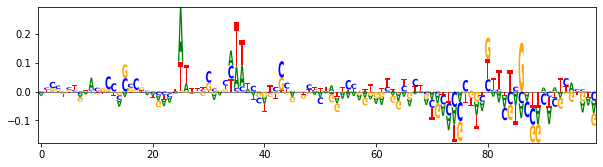

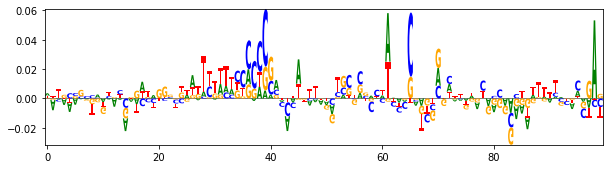

In [80]:
ex_impact_map = impact_maps[5]
ex_impact_map_df = pandas.DataFrame(ex_impact_map[:, 400:500].T, columns=["A", "C", "T", "G"])
Logo(ex_impact_map_df)
ex_impact_map = impact_maps[6]
ex_impact_map_df = pandas.DataFrame(ex_impact_map[:, 400:500].T, columns=["A", "C", "T", "G"])
Logo(ex_impact_map_df)

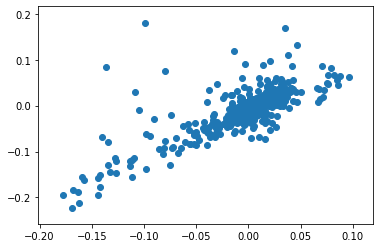

In [85]:
for null_impact_summary, impact_summary in similarity_metrics[:1]:
    for position in range(len(impact_summary)):
        plt.scatter(null_impact_summary, impact_summary)

In [ ]:
sw_scores = np.zeros((2, len(foxa1_pwms), n_seqs // 2, len(neg_sig_muts[0])))
    
for i in tqdm(range(n_seqs // 2)):
    for k, pwm in enumerate(foxa1_pwms):
        M = pwm.shape[1]
        seq = seqs[i]
        
        effs = neg_sig_muts[i]
        ref_seq_contexts = np.zeros((len(effs), n_nts, 2*M + 1))
        mut_seq_contexts = np.zeros((len(effs), n_nts, 2*M + 1))
        for j, eff in enumerate(effs):
            seq_pos, nt_idx = eff.seq_idx
            start, end = max(seq_pos - M, 0), min(seq_pos + M + 1, seq_len)
            ref_seq_contexts[j, :, : end-start] = seq[:, start:end]
            mut_seq_contexts[j, :, : end-start] = seq[:, start:end]
            mut_seq_contexts[j, :, M] = np.zeros(4)
            mut_seq_contexts[j, nt_idx, M] = 1

        ref_scores, _ = prob_sw(pwm, ref_seq_contexts, w=.2)
        mut_scores, _ = prob_sw(pwm, mut_seq_contexts, w=.2)
        sw_scores[:, k, i, :] = np.stack((ref_scores, mut_scores), axis=0)

In [ ]:
fig, axs = plt.subplots((n_seqs // 2) * len(foxa1_pwms), figsize=(16, len(foxa1_pwms) * (n_seqs) * 3))
sw_score_diffs = sw_scores[0, :, :, :] - sw_scores[1, :, :, :]

for i in range(n_seqs // 2):
    for k, pwm in enumerate(foxa1_pwms):
        ax = axs[(i * len(foxa1_pwms) + k)]
        effs = [(mut.eff) for mut in neg_sig_muts[i]]
        corr = np.corrcoef(effs, sw_score_diffs[k, i, :])
        ax.scatter(effs, sw_score_diffs[k, i, :], alpha=.3)
        xlabel = "binding prob diff"
        ylabel = "sw score diff (ref - mut)"
        ax.set_title(f"seq {i}, pwm {k} (corr: {corr[0, 1]})")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)